In [1]:
%matplotlib inline
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Introduction to Deep Learning with Keras and TensorFlow

Based on excelent work by **[Daniel Moser (UT Southwestern Medical Center)](https://github.com/AviatorMoser/keras-mnist-tutorial)**, Resources: **[Xavier Snelgrove](https://github.com/wxs/keras-mnist-tutorial), [Yash Katariya](https://github.com/yashk2810/MNIST-Keras)**

To help you understand the fundamentals of deep learning, this demo will walk through the basic steps of building two toy models for classifying handwritten numbers with accuracies surpassing 95%. The first model will be a basic fully-connected neural network, and the second model will be a deeper network that introduces the concepts of convolution and pooling.

## The Task for the AI

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. We will use the Keras Python API with TensorFlow as the backend.

<img src="https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/mnist.png" >

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [2]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

import tensorflow as tf

from keras.datasets import mnist     # MNIST dataset is included in Keras%
from keras.models import Sequential  # Model type to be used

from keras.layers import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

from keras import optimizers


from sklearn.metrics import confusion_matrix
import itertools

print(tf.__version__)

2.12.0


## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [3]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook. We can egzamine the interclass variability - how many different ways of writing the same digit there are!

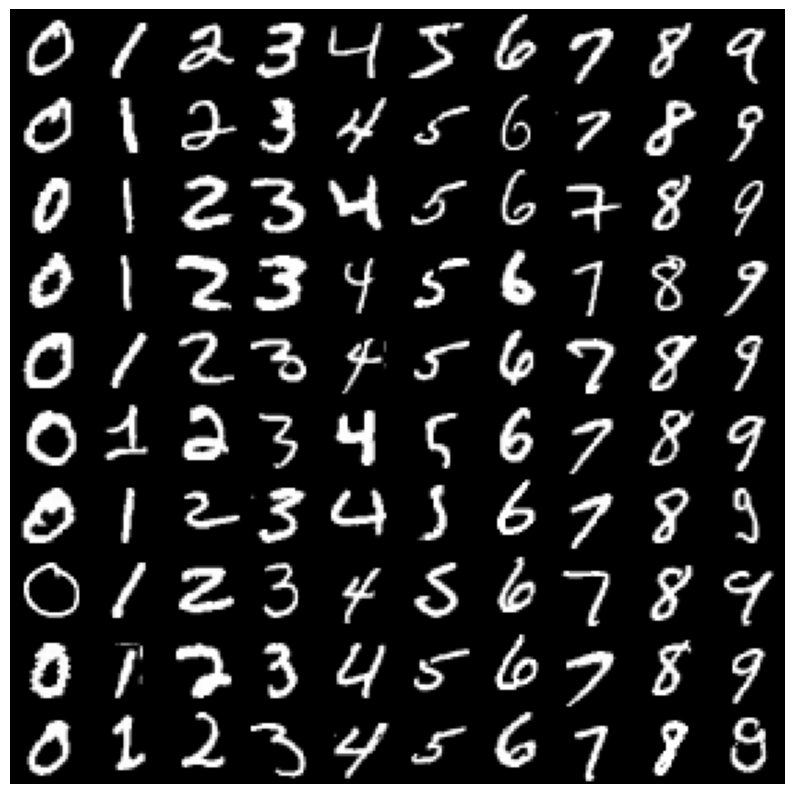

In [4]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

def visualize_classes(X, y):
  for i in range(0, 10):
    img_batch = X[y == i][0:10]
    img_batch = np.reshape(img_batch, (img_batch.shape[0]*img_batch.shape[1], img_batch.shape[2]))
    if i > 0:
      img = np.concatenate([img, img_batch], axis = 1)
    else:
      img = img_batch
  plt.figure(figsize=(10,20))
  plt.axis('off')
  plt.imshow(img, cmap='gray')


visualize_classes(X_train, y_train)


Let's examine a single digit a little closer, and print out the array representing the last digit.

In [5]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!        
matprint(X_train[-1])

0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0   38   48   48   22    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0   62   97  198  243  254  254  212   27    0    0    0    0    0  0  0  


Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.

*Fun-fact! Your computer screen has three channels for each pixel: red, green, blue. Each of these channels also likely takes an 8-bit integer. 3 channels -- 24 bits total -- 16,777,216 possible colors!*

## More input data nalysis


Visualizing high-dimensional data by projecting it into a low-dimensional space is a classic operation that anyone working with data has probably done at least once in their life. There are a huge variety of methods for reducing dimensionality, but one very popular method is t-SNE, a method proposed by Geoffry Hinton’s group back in 2008. [ _more..._ ](https://mlexplained.com/2018/09/14/paper-dissected-visualizing-data-using-t-sne-explained/)

Code by [Zaid Alyafeai](https://github.com/zaidalyafeai/Notebooks) [MIT license]

In [6]:
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
import seaborn as sns

RS=19238

class_names = [ str(clid) for clid in range(10) ]
    
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype("int")])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, class_names[i], fontsize=15)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
def plot_tsne(X, y):
  print('calculating tsne ...')
  proj = TSNE(random_state=RS, learning_rate=200, init='random').fit_transform(X)
  scatter(proj, y)

calculating tsne ...


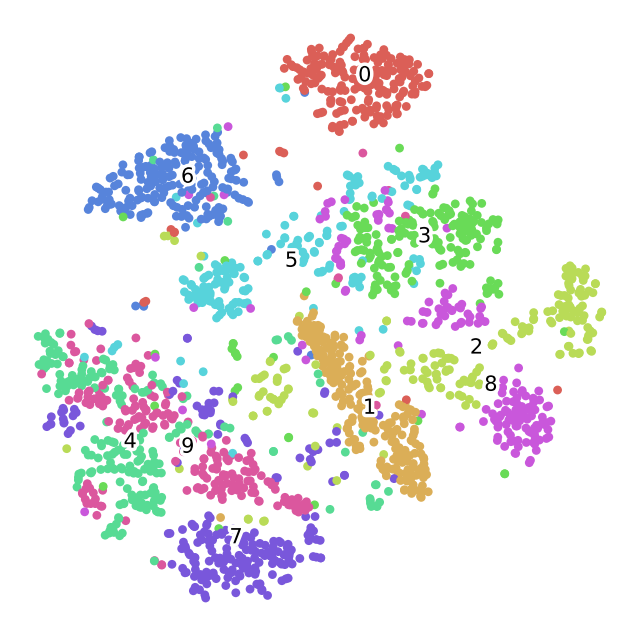

In [7]:
X = np.reshape(X_train, (X_train.shape[0], 28 * 28))[0:2000]
y = y_train[0:2000]
plot_tsne(X, y)

## Formatting the input data layer

Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

<img src='https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/flatten.png' >

In [8]:
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


We then modify our classes (unique digits) to be in the one-hot (categorical) format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

In [9]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Building a 3-layer fully connected network

<img src="https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/figure.png" />

In [10]:
# The Sequential model is a linear stack of layers and is very common.

model = Sequential()

## The first hidden layer

In [11]:
# The first hidden layer is a set of 512 nodes (artificial neurons).
# Each node will receive an element from each input vector and apply some weight and bias to it.

model.add(Dense(512, input_shape=(784,))) #(784,) is not a typo -- that represents a 784 length vector!

In [12]:
# An "activation" is a non-linear function applied to the output of the layer above.
# It checks the new value of the node, and decides whether that artifical neuron has fired.
# The Rectified Linear Unit (ReLU) converts all negative inputs to nodes in the next layer to be zero.
# Those inputs are then not considered to be fired.
# Positive values of a node are unchanged.

model.add(Activation('relu'))

$$f(x) = max (0,x)$$
<img src = 'https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/relu.jpg' >

In [13]:
# Dropout zeroes a selection of random outputs (i.e., disables their activation)
# Dropout helps protect the model from memorizing or "overfitting" the training data.
model.add(Dropout(0.2))

## Adding the second hidden layer

In [14]:
# The second hidden layer appears identical to our first layer.
# However, instead of each of the 512-node receiving 784-inputs from the input image data,
# they receive 512 inputs from the output of the first 512-node layer.

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

## The Final Output Layer

In [15]:
# The final layer of 10 neurons in fully-connected to the previous 512-node layer.
# The final layer of a FCN should be equal to the number of desired classes (10 in this case).
model.add(Dense(10))

In [16]:
# The "softmax" activation represents a probability distribution over K different possible outcomes.
# Its values are all non-negative and sum to 1.

model.add(Activation('softmax'))

In [17]:
# Summarize the built model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5

## Compiling the model

Keras is built on top of Theano and TensorFlow. Both packages allow you to define a *computation graph* in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical cross-entropy*, and is a loss function well-suited to comparing two probability distributions.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns through **gradient descent**. The rate at which descends a gradient is called the **learning rate**.

<img src = "https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/gradient_descent.png" >

<img src = "https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/learning_rate.png" >

So are smaller learning rates better? Not quite! It's important for an optimizer not to get stuck in local minima while neglecting the global minimum of the loss function. Sometimes that means trying a larger learning rate to jump out of a local minimum.

<img src = 'https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/complicated_loss_function.png' >

In [18]:
# Let's use the Adam optimizer for learning
adam = tf.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

## Train the model!
This is the fun part! 

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

In [19]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=5,
          verbose=1)

Epoch 1/5
469/469 [==============================] - 7s 3ms/step - loss: 0.2479 - accuracy: 0.9253
Epoch 2/5
469/469 [==============================] - 2s 3ms/step - loss: 0.1003 - accuracy: 0.9690
Epoch 3/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0708 - accuracy: 0.9777
Epoch 4/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0576 - accuracy: 0.9813
Epoch 5/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0428 - accuracy: 0.9861


The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. But how does it do on data it did not train on?

## Evaluate Model's Accuracy on Test Data

In [20]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0813 - accuracy: 0.9771
Test score: 0.08130984753370285
Test accuracy: 0.9771000146865845


In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

313/313 [==============================] - 1s 1ms/step
Confusion matrix, without normalization
[[ 973    1    1    2    0    0    0    1    2    0]
 [   0 1113    3    4    0    0    1    0   14    0]
 [   2    0 1018    4    1    0    0    3    4    0]
 [   0    0    1 1003    0    1    0    3    1    1]
 [   1    0    6    0  934    1    3    3    1   33]
 [   2    0    0   17    1  866    1    0    4    1]
 [   8    3    3    1    4    9  925    0    5    0]
 [   1    3   12    7    0    0    0  997    2    6]
 [   0    0    3    7    1    4    0    2  952    5]
 [   3    2    0    9    3    0    0    2    0  990]]


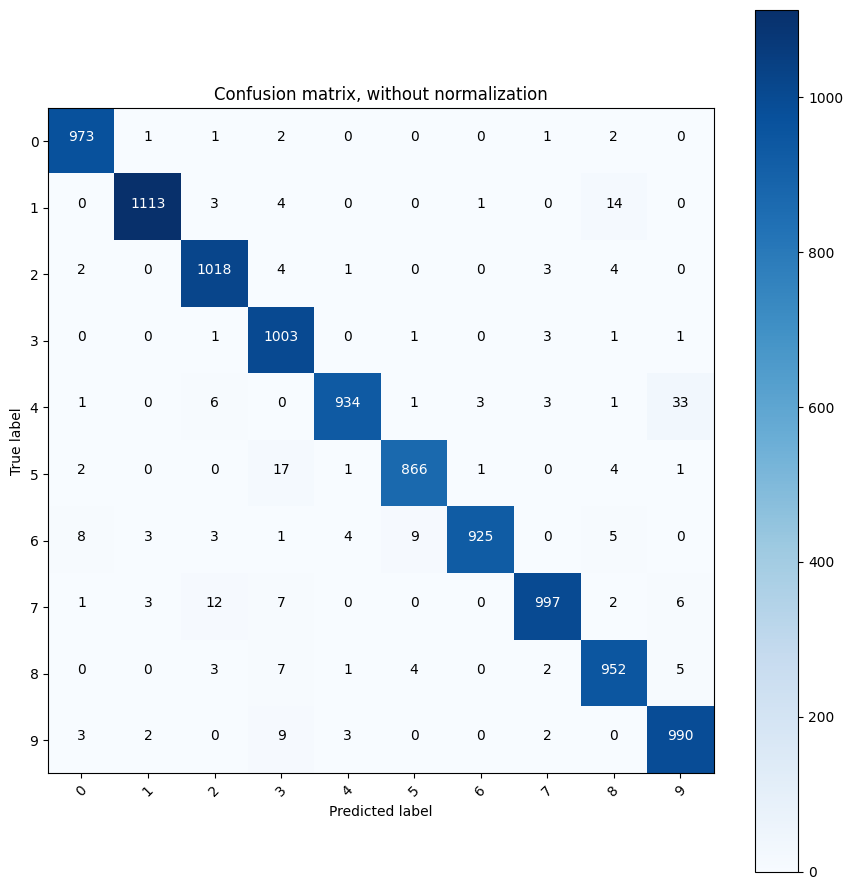

In [22]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predict = model.predict(X_test)
predicted_classes = np.argmax(predict,axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

cnf_matrix = confusion_matrix(y_test, predicted_classes)

class_names = [str(i) for i in range(10)]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()


**Correct predictions**

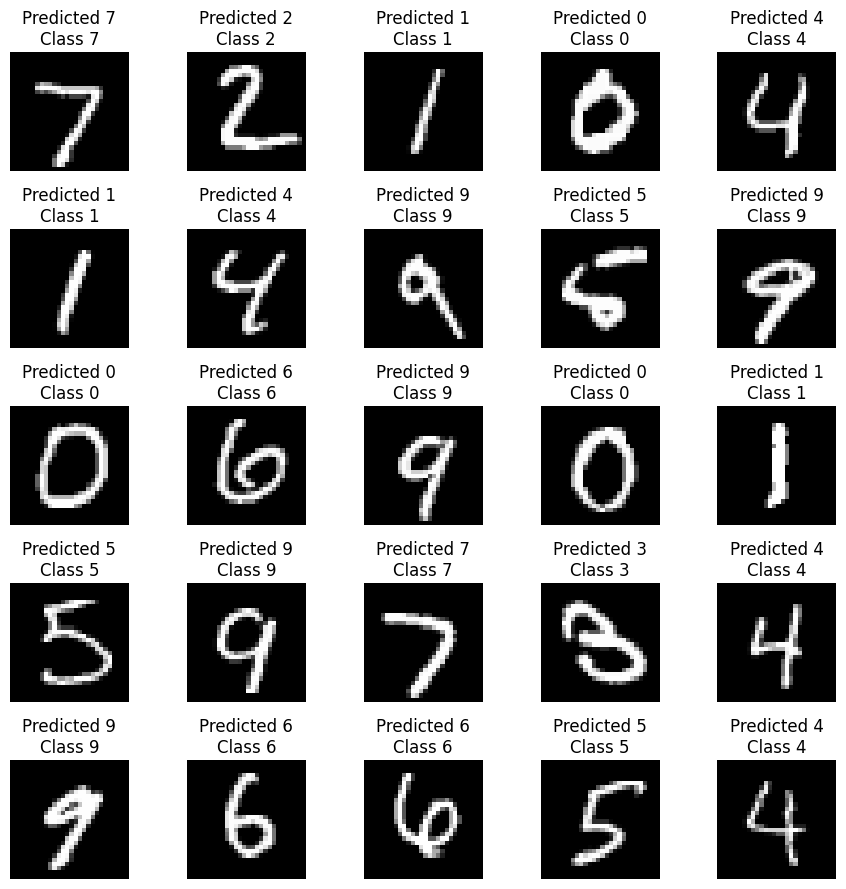

In [23]:
def show_samples(indices, preds, images, labels, count=3, names = []):
    plt.figure()
    for i, sample in enumerate(indices[:count**2]):
        plt.subplot(count,count,i+1)
        plt.imshow(images[sample].reshape(28,28), cmap='gray', interpolation='none')
        plt.axis('off')
        if len(names) > 0:
          plt.title("Predicted {}\nClass {}".format(names[int(preds[sample])], names[int(labels[sample])]))
        else:
          plt.title("Predicted {}\nClass {}".format(preds[sample], labels[sample]))          
    
    plt.tight_layout()

show_samples(correct_indices, predicted_classes, X_test, y_test, 5)

**Wrong predictions**

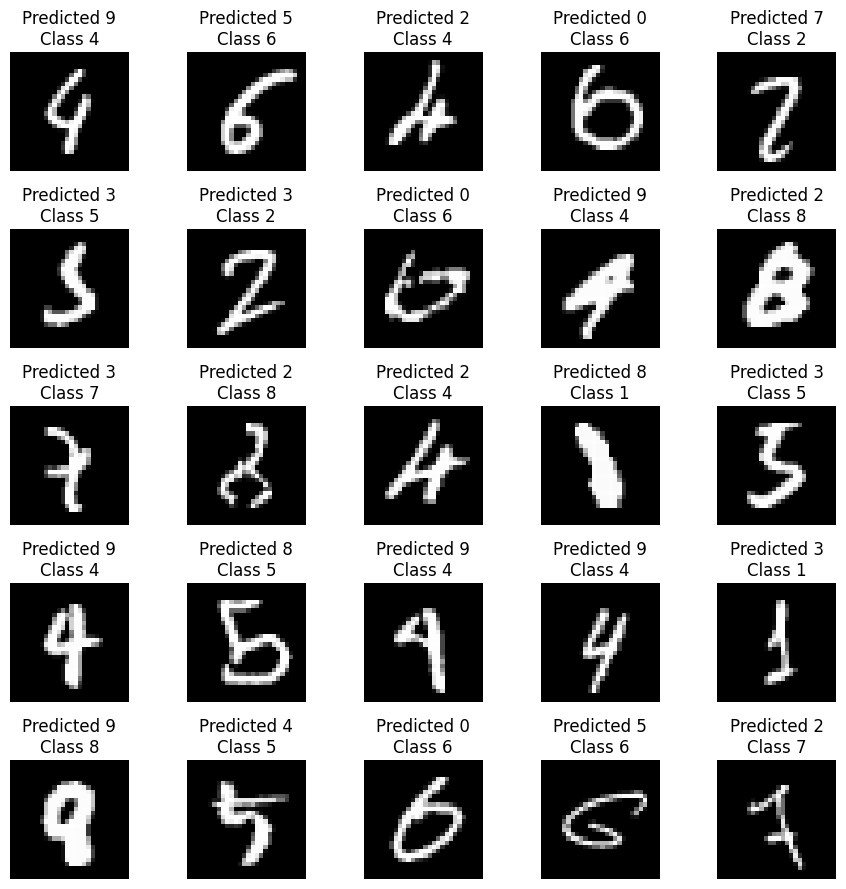

In [24]:
show_samples(incorrect_indices, predicted_classes, X_test, y_test, 5)

# Try experimenting with the batch size!

   * How does increasing the batch size to 10,000 affect the training time and test accuracy?
   * How about a batch size of 32?
   * Is there any difference in results between the students? If so - why?
   * Experiment with the learning rate in the optimizer

# Introducing Convolution! What is it?

Before, we built a network that accepts the normalized pixel values of each value and operates soley on those values. What if we could instead feed different features (e.g. **curvature, edges**) of each image into a network, and have the network learn which features are important for classifying an image?

This possible through convolution! Convolution applies **kernels** (filters) that traverse through each image and generate **feature maps**.

<img src = 'https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/convolution.gif' >

In the above example, the image is a 5 x 5 matrix and the kernel going over it is a 3 x 3 matrix. A dot product operation takes place between the image and the kernel and the convolved feature is generated. Each kernel in a CNN learns a different characteristic of an image.

Kernels are often used in photoediting software to apply blurring, edge detection, sharpening, etc.

<img src = 'https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/kernels.png' >

Kernels in deep learning networks are used in similar ways, i.e. highlighting some feature. Combined with a system called **max pooling**, the non-highlighted elements are discarded from each feature map, leaving only the features of interest, reducing the number of learned parameters, and decreasing the computational cost (e.g. system memory).

<img src = 'https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/max_pooling.png' >

We can also take convolutions of convolutions -- we can stack as many convolutions as we want, as long as there are enough pixels to fit a kernel.

*Warning: What you may find down there in those deep convolutions may not appear recognizable to you.*

<img src = 'https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/go_deeper.jpg' >

## Building a "Deep" Convolutional Neural Network

In [25]:
# import some additional tools

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers import BatchNormalization

In [26]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [27]:
# Again, do some formatting
# Except we do not flatten each image into a 784-length vector because we want to perform convolutions first

X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [28]:
# one-hot format classes

nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [29]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(16, (5, 5), input_shape=(28,28,1))) # 16 different 5x5 kernels -- so 16 feature maps
model.add(Activation('relu') )                       # activation
model.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel

# Convolution Layer 2
model.add(Conv2D(32, (5, 5)))                        # 32 different 5x5 kernels -- so 32 feature maps
model.add(Activation('relu'))                        # activation
model.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel

model.add(Flatten())                                 # Flatten final output matrix into a vector

# Fully Connected Layer 
model.add(Dense(128))                                # 128 FC nodes
model.add(Activation('relu'))                        # activation

# Fully Connected Layer                        
model.add(Dense(10))                                 # final 10 FC nodes
model.add(Activation('softmax'))                     # softmax activation

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 16)        416       
                                                                 
 activation_3 (Activation)   (None, 24, 24, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          12832     
                                                                 
 activation_4 (Activation)   (None, 8, 8, 32)          0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                  

In [31]:
# we'll use the same optimizer
adam = tf.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [32]:
# data augmentation prevents overfitting by slightly changing the data randomly
# Keras has a great built-in feature to do automatic augmentation

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08, validation_split=0.2)

test_gen = ImageDataGenerator()

In [33]:
# We can then feed our augmented data in batches
# Besides loss function considerations as before, this method actually results in significant memory savings
# because we are actually LOADING the data into the network in batches before processing each batch

# Before the data was all loaded into memory, but then processed in batches.

train_generator = gen.flow(X_train, Y_train, batch_size=128, subset='training')
valid_generator = gen.flow(X_train, Y_train, batch_size=128, subset='validation')
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [34]:
# We can now train our model which is fed data by our batch loader
# Steps per epoch should always be total size of the set divided by the batch size

# SIGNIFICANT MEMORY SAVINGS (important for larger, deeper networks)

model.fit(train_generator, steps_per_epoch=48000//128, epochs=5, verbose=1, validation_data=valid_generator, validation_steps = 12000 // 128)

Epoch 1/5
375/375 [==============================] - 26s 51ms/step - loss: 0.4436 - accuracy: 0.8641 - val_loss: 0.1610 - val_accuracy: 0.9523
Epoch 2/5
375/375 [==============================] - 17s 46ms/step - loss: 0.1343 - accuracy: 0.9584 - val_loss: 0.1132 - val_accuracy: 0.9668
Epoch 3/5
375/375 [==============================] - 18s 48ms/step - loss: 0.0951 - accuracy: 0.9700 - val_loss: 0.0865 - val_accuracy: 0.9740
Epoch 4/5
375/375 [==============================] - 19s 51ms/step - loss: 0.0746 - accuracy: 0.9768 - val_loss: 0.0660 - val_accuracy: 0.9785
Epoch 5/5
375/375 [==============================] - 20s 53ms/step - loss: 0.0661 - accuracy: 0.9793 - val_loss: 0.0665 - val_accuracy: 0.9808


In [35]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0336 - accuracy: 0.9889
Test score: 0.03361314535140991
Test accuracy: 0.9889000058174133


313/313 [==============================] - 1s 2ms/step
Confusion matrix, without normalization
[[ 976    0    0    0    0    0    0    2    2    0]
 [   0 1125    2    0    0    0    0    1    7    0]
 [   0    0 1027    2    1    0    0    1    1    0]
 [   0    0    1 1005    0    3    0    1    0    0]
 [   0    0    0    0  978    0    0    1    0    3]
 [   0    0    0    4    0  887    1    0    0    0]
 [   6    3    0    1    2   19  926    0    1    0]
 [   0    1    5    1    1    0    0 1019    1    0]
 [   0    0    1    2    1    3    0    2  962    3]
 [   0    0    2    1    7    9    0    4    2  984]]


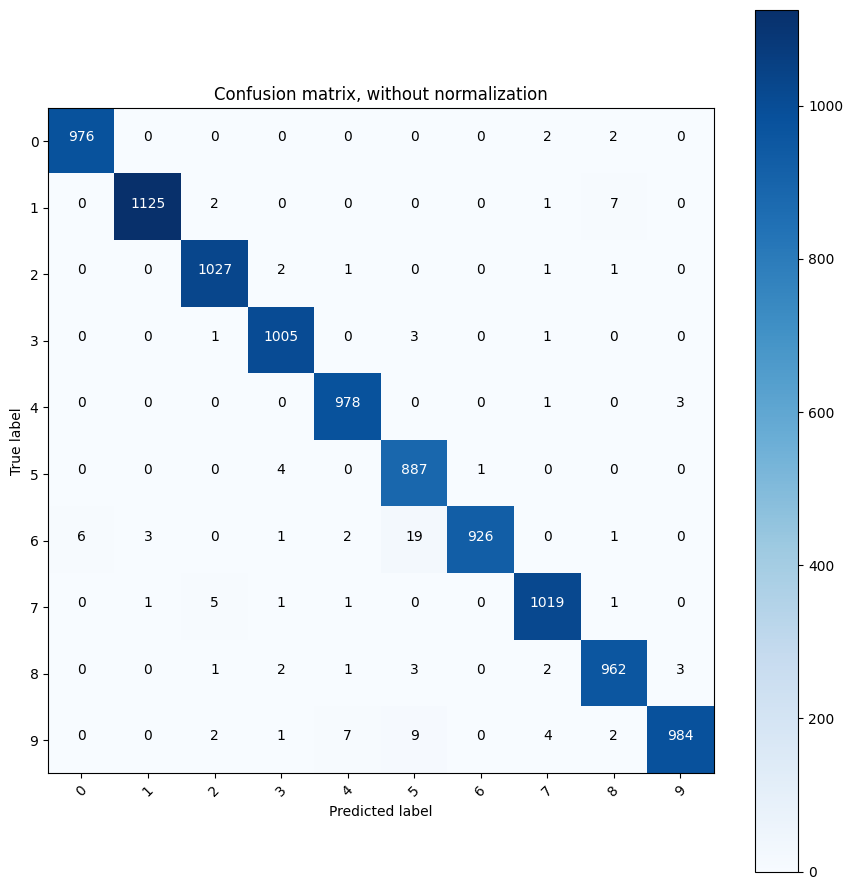

In [36]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predict = model.predict(X_test)
predicted_classes = np.argmax(predict,axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]


cnf_matrix = confusion_matrix(y_test, predicted_classes)

class_names = [str(i) for i in range(10)]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

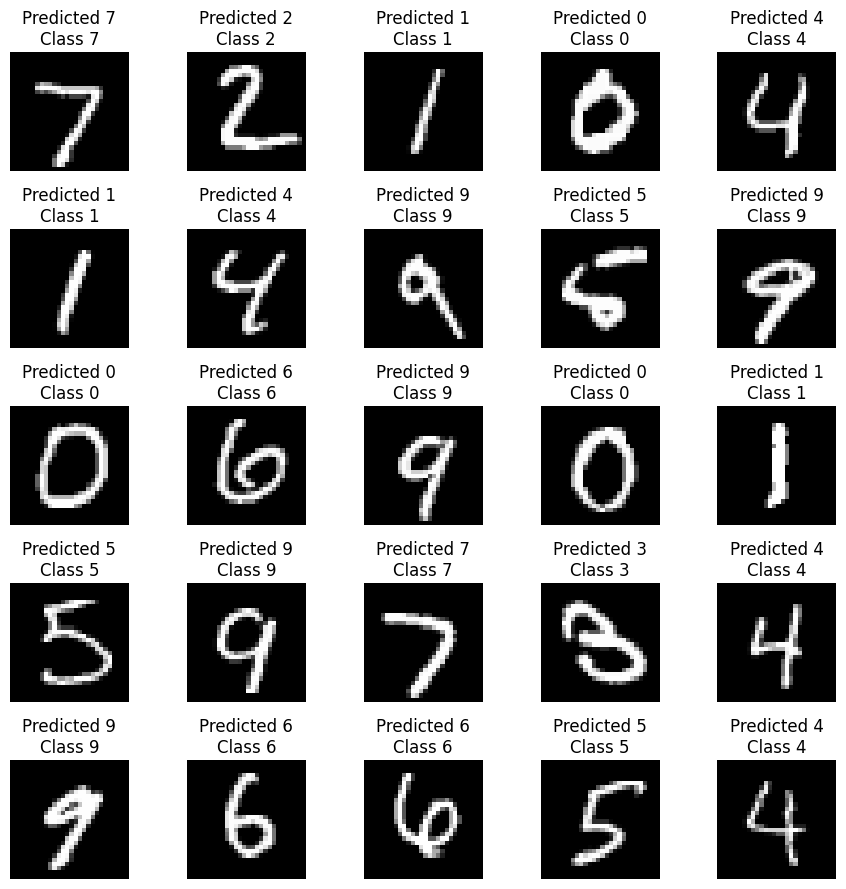

In [37]:
show_samples(correct_indices, predicted_classes, X_test, y_test, 5)

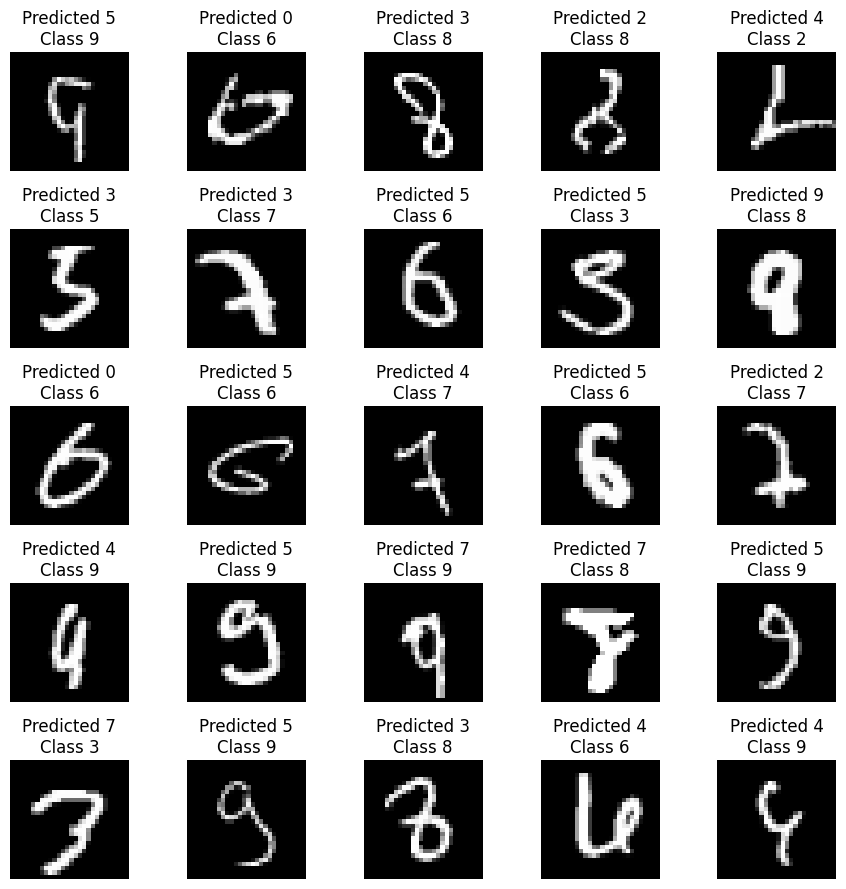

In [38]:
show_samples(incorrect_indices, predicted_classes, X_test, y_test, 5)

## Great results! 

But wouldn't it be nice if we could visualize those convolutions so that we can see what the model is seeing?

In [39]:
def visualize2(model, layer, img, r, c):
  from keras import Model
  # expand dimensions so that it represents a single 'sample'
  img = np.expand_dims(img, axis=0)
  outputs = [layer.output]
  model = Model(inputs=model.inputs, outputs=outputs)
  # get feature map for first hidden layer
  feature_maps = model.predict(img)
  for fmap in feature_maps:
  # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(r):
      for _ in range(c):
        # specify subplot and turn of axis
        ax = plt.subplot(r, c, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(fmap[:, :, ix-1], cmap='gray')
        ix += 1

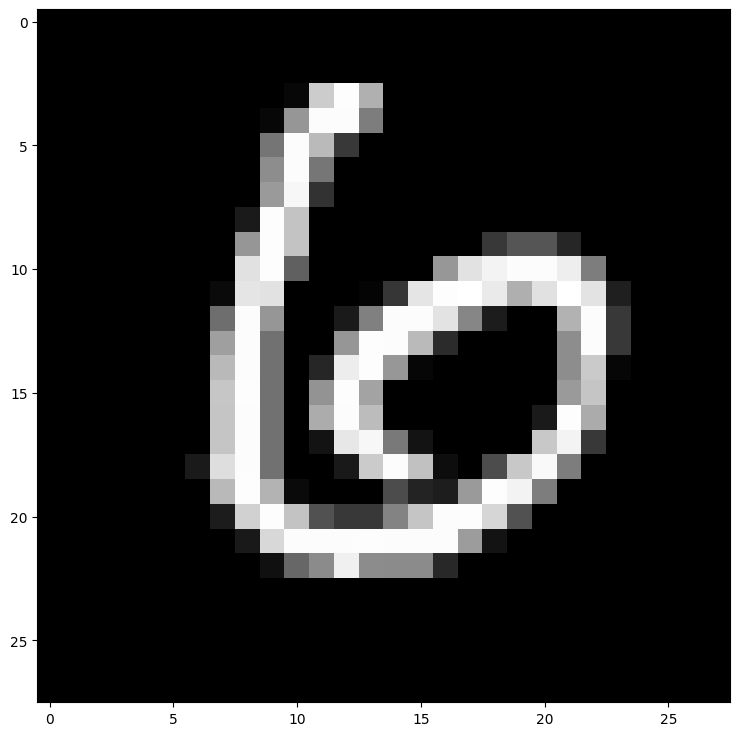

In [40]:
plt.figure()
img = X_test[11]
plt.imshow(img[:,:,0], cmap='gray', interpolation='none')

1/1 [==============================] - 0s 63ms/step


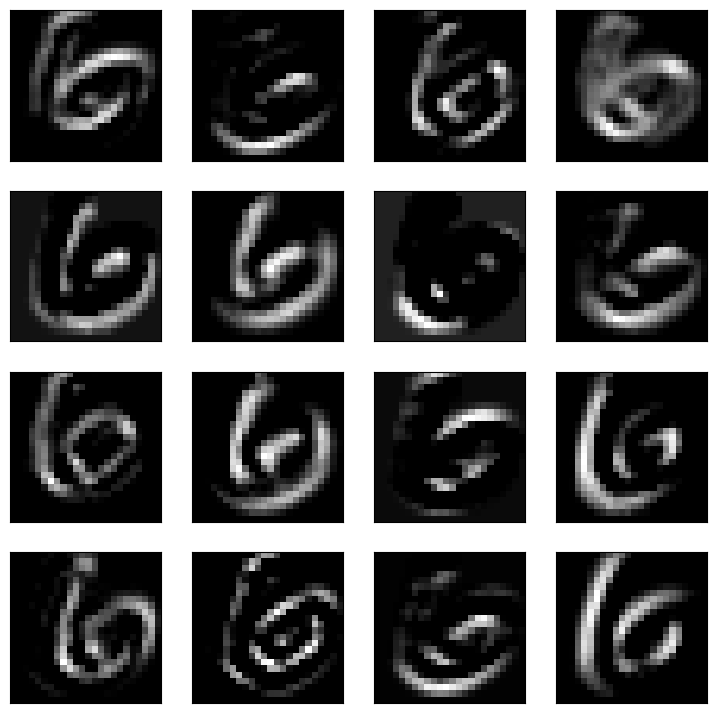

In [41]:
visualize2(model, model.layers[1], img, 4, 4)

1/1 [==============================] - 0s 115ms/step


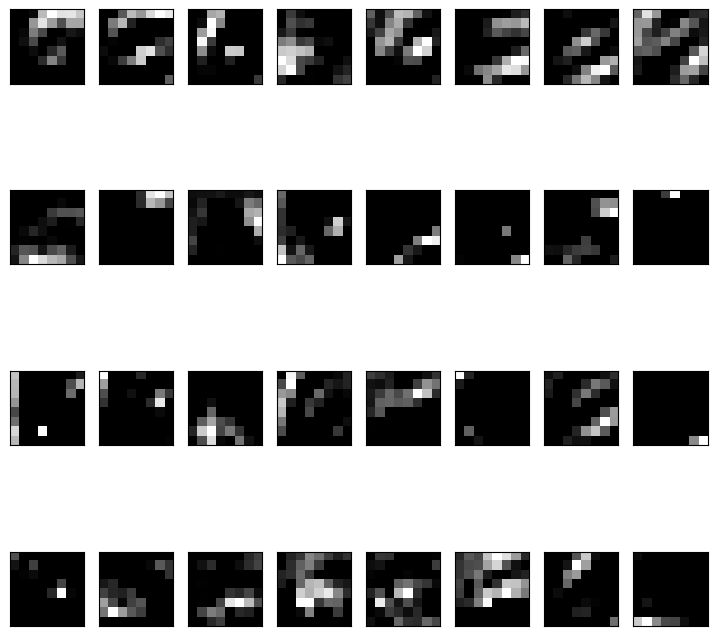

In [42]:
visualize2(model, model.layers[4], img, 4, 8)

# Transfer learning

## Funkcje pomocnicze

In [43]:
# Loading the specified subset of digits from the MNIST dataset
def get_mnist(digits):
  # Reload the MNIST data
  (X_train, y_train), (X_test, y_test) = mnist.load_data()

  train_ids = np.in1d(y_train, digits)
  test_ids = np.in1d(y_test, digits)
  X_train = X_train[train_ids]
  X_test = X_test[test_ids]
  y_train = y_train[train_ids]
  y_test = y_test[test_ids]

  X_train = np.expand_dims(X_train, axis=-1)
  X_test = np.expand_dims(X_test, axis=-1)

  X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
  X_test = X_test.astype('float32')

  X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
  X_test /= 255

  return X_train, y_train, X_test, y_test

In [44]:
# Preparing the base model
def prepare_model(input_shape, class_count):
  model = Sequential()                                 # Linear stacking of layers

  # Convolution Layer 1
  model.add(Conv2D(16, (3, 3), padding="same", input_shape=input_shape)) 
  model.add(Activation('relu') )                      
  model.add(MaxPooling2D(pool_size=(2,2)))             

  # Convolution Layer 2
  model.add(Conv2D(32, (3, 3), padding="same"))                     
  model.add(Activation('relu'))                        
  model.add(MaxPooling2D(pool_size=(2,2)))            

  # Convolution Layer 3
  model.add(Conv2D(64, (3, 3), padding="same"))                        
  model.add(Activation('relu'))                        
  model.add(MaxPooling2D(pool_size=(2,2)))  

  model.add(Flatten())                                

  # Fully Connected Layer 
  model.add(Dense(64))                               
  model.add(Activation('relu'))                     

  # Fully Connected Layer                        
  model.add(Dense(class_count))                        
  model.add(Activation('softmax')) 

  return model       

In [45]:
# One-hot encoding of non-consecutive labels
def one_hot(labels):
  from sklearn.preprocessing import OneHotEncoder
  encoder = OneHotEncoder(categories='auto')
  l = labels.reshape(-1, 1)
  output = encoder.fit_transform(l)
  return output.toarray()

In [46]:
def test_model(model, X_test, Y_test, y_test, digits):
  score = model.evaluate(X_test, Y_test)
  print('Test score:', score[0])
  print('Test accuracy:', score[1])

  # The predict_classes function outputs the highest probability class
  # according to the trained classifier for each input example.
  predicted = model.predict(X_test)
  predicted_classes = np.argmax(predicted, axis=1)

  actual_classes = [digits[x] for x in predicted_classes]

  # Check which items we got right / wrong
  correct_indices = np.nonzero(actual_classes == y_test)[0]

  incorrect_indices = np.nonzero(actual_classes != y_test)[0]


  cnf_matrix = confusion_matrix(y_test, actual_classes)

  class_names = [str(i) for i in digits]

  # Plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=class_names,
                        title='Confusion matrix, without normalization')

  plt.show()

## Trening modelu bazowego: cyfry 0..4

In [47]:
digits = [0, 1, 2, 3, 4]

X_train, y_train, X_test, y_test = get_mnist(digits)

Y_train = one_hot(y_train)
Y_test = one_hot(y_test)

model = prepare_model( (28, 28, 1), 5)

adam = tf.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 activation_7 (Activation)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 activation_8 (Activation)   (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                  

In [48]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08, validation_split=0.2)

test_gen = ImageDataGenerator()

train_generator = gen.flow(X_train, Y_train, batch_size=128, subset='training')
valid_generator = gen.flow(X_train, Y_train, batch_size=128, subset='validation')
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [49]:
model.fit_generator(train_generator, steps_per_epoch=25000//128, epochs=5, verbose=1, validation_data=valid_generator, validation_steps = 5000 // 128)

Epoch 1/5


<ipython-input-49-1bedfa515cd7>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=25000//128, epochs=5, verbose=1, validation_data=valid_generator, validation_steps = 5000 // 128)


192/195 [============================>.] - ETA: 0s - loss: 0.2889 - accuracy: 0.9076

195/195 [==============================] - 12s 49ms/step - loss: 0.2889 - accuracy: 0.9076 - val_loss: 0.0690 - val_accuracy: 0.9804


161/161 [==============================] - 1s 3ms/step - loss: 0.0278 - accuracy: 0.9920
Test score: 0.027833769097924232
Test accuracy: 0.9920217990875244
161/161 [==============================] - 0s 2ms/step
Confusion matrix, without normalization
[[ 979    1    0    0    0]
 [   0 1129    4    2    0]
 [  13    2 1008    6    3]
 [   1    0    4 1004    1]
 [   1    1    2    0  978]]


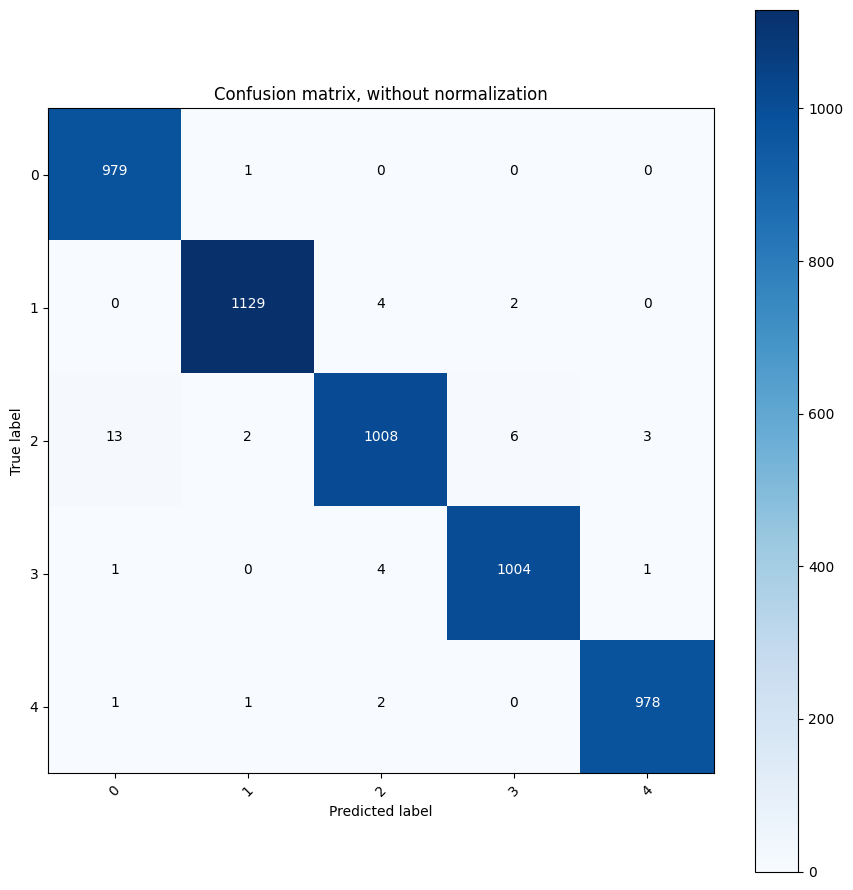

In [50]:
test_model(model, X_test, Y_test, y_test, digits)

## Transfer wiedzy do nowego modelu: cyfry 5..9

In [51]:
# Extract specified range of layers to a new sequential model
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
  # create an empty model
  new_model = Sequential()
  for ix in range(starting_layer_ix, ending_layer_ix + 1):
    curr_layer = main_model.get_layer(index=ix)
    # copy this layer over to the new model
    new_model.add(curr_layer)
  return new_model

Nowy model stworzony jest na bazie wytrenowanego modelu bazowego. Część odpowiedzialna za detekcję cech w obrazie (warstwy splotowe) są wykorzystywane jako podstawa dla nowej sieci. Część klasyfikacyjna jest dodawana na nowo, z losowo zainicjowanymi wagami.

Warstwy splotowe były wstępnie wytrenowane w modelu bazowym, więc są zamrażane. Treningowi podlega tylko część klasyfikacyjna.

In [56]:
new_model = extract_layers(model, 0, 9)

# Fully Connected Layer 
new_model.add(Dense(64)) 
new_model.add(Activation('relu'))

# Fully Connected Layer                        
new_model.add(Dense(5))
new_model.add(Activation('softmax')) 

for ix in range(0, 9+1):
  new_model.get_layer(index=ix).trainable=False

new_digits = [5, 6, 7, 8, 9]

X_train, y_train, X_test, y_test = get_mnist(new_digits)

Y_train = one_hot(y_train)
Y_test = one_hot(y_test)

new_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(), metrics=['accuracy'])

new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 activation_7 (Activation)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 activation_8 (Activation)   (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                  

In [57]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08, validation_split=0.2)

test_gen = ImageDataGenerator()

train_generator = gen.flow(X_train, Y_train, batch_size=128, subset='training')
valid_generator = gen.flow(X_train, Y_train, batch_size=128, subset='validation')
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

Trening nowego modelu

In [58]:
new_model.fit_generator(train_generator, steps_per_epoch=24000//128, epochs=5, verbose=1, validation_data=valid_generator, validation_steps = 6000 // 128)

Epoch 1/5


<ipython-input-58-05ca407e5c2c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  new_model.fit_generator(train_generator, steps_per_epoch=24000//128, epochs=5, verbose=1, validation_data=valid_generator, validation_steps = 6000 // 128)


184/187 [============================>.] - ETA: 0s - loss: 0.4573 - accuracy: 0.8647

187/187 [==============================] - 9s 48ms/step - loss: 0.4573 - accuracy: 0.8647 - val_loss: 0.2258 - val_accuracy: 0.9264


152/152 [==============================] - 0s 3ms/step - loss: 0.1375 - accuracy: 0.9597
Test score: 0.13747498393058777
Test accuracy: 0.9596790671348572
152/152 [==============================] - 0s 2ms/step
Confusion matrix, without normalization
[[873   4   1   7   7]
 [  2 954   0   2   0]
 [  0   0 983   5  40]
 [  9  18  12 878  57]
 [ 10   6  11   5 977]]


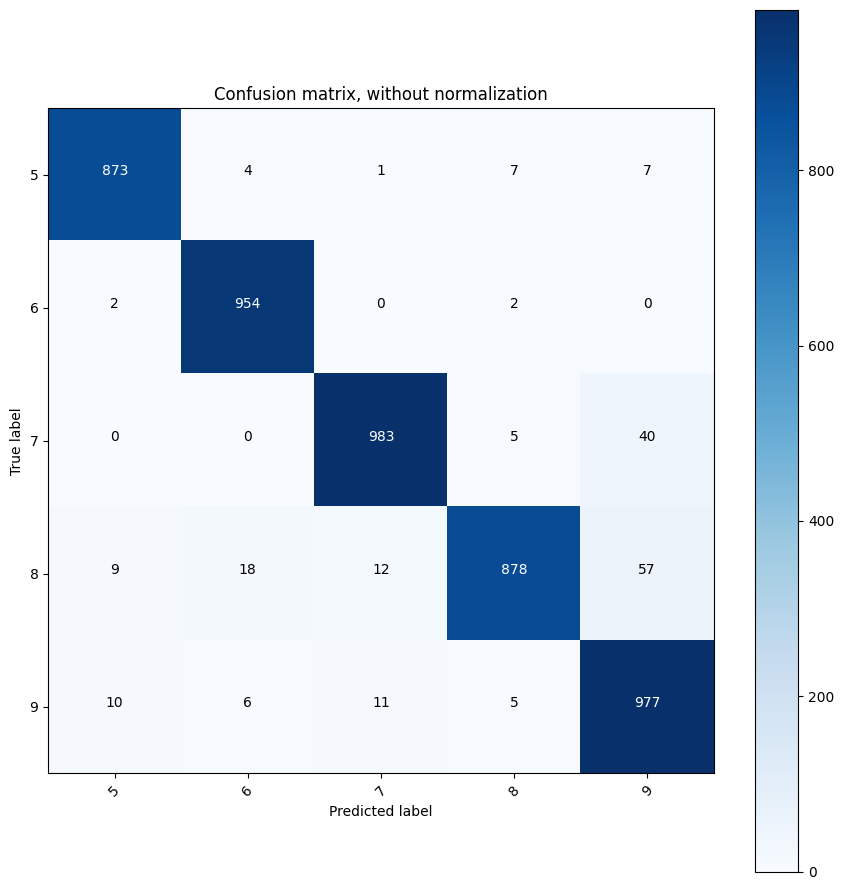

In [59]:
test_model(new_model, X_test, Y_test, y_test, new_digits)

## Fine-tuning

Po wytrenowaniu części klasyfikacyjnej można ponownie odmrozić wszystkie warstwy i przeprowadzić dotrenowanie pełnej sieci na nowych danych, bez ryzyka związanego z dużymi gradientami w pierwszych fazach uczenia.

In [60]:
for ix in range(0, 9+1):
  new_model.get_layer(index=ix).trainable=True

new_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(), metrics=['accuracy'])
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 activation_7 (Activation)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 activation_8 (Activation)   (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                  

In [61]:
new_model.fit_generator(train_generator, steps_per_epoch=24000//128, epochs=2, verbose=1, validation_data=valid_generator, validation_steps = 6000 // 128)

<ipython-input-61-5ed88bbb5f18>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  new_model.fit_generator(train_generator, steps_per_epoch=24000//128, epochs=2, verbose=1, validation_data=valid_generator, validation_steps = 6000 // 128)


Epoch 1/2
184/187 [============================>.] - ETA: 0s - loss: 0.1518 - accuracy: 0.9512

187/187 [==============================] - 10s 44ms/step - loss: 0.1518 - accuracy: 0.9512 - val_loss: 0.0936 - val_accuracy: 0.9701


152/152 [==============================] - 0s 3ms/step - loss: 0.0442 - accuracy: 0.9879
Test score: 0.04423364996910095
Test accuracy: 0.9878625869750977
152/152 [==============================] - 0s 2ms/step
Confusion matrix, without normalization
[[ 881    1    2    4    4]
 [   1  954    0    3    0]
 [   0    0 1021    3    4]
 [   7    1    5  956    5]
 [   3    3    9    4  990]]


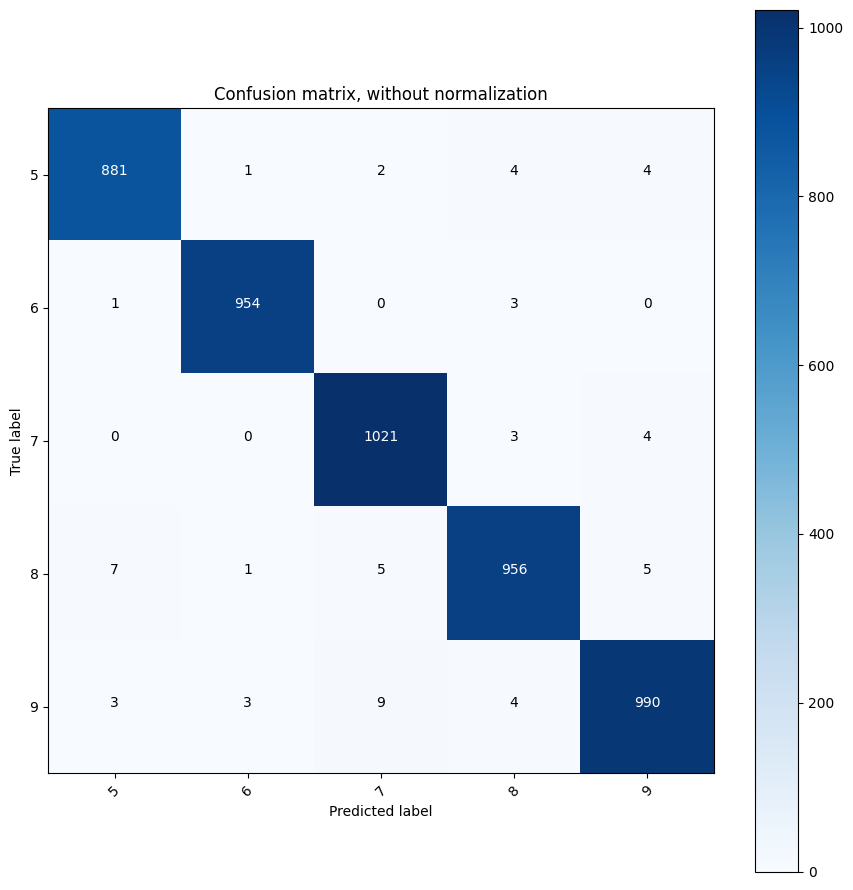

In [62]:
test_model(new_model, X_test, Y_test, y_test, new_digits)

# Test on different dataset

In [64]:
!wget https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt

--2023-04-12 18:25:20--  https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2791 (2.7K) [text/plain]
Saving to: ‘categories.txt.1’

categories.txt.1    100%[===================>]   2.73K  --.-KB/s    in 0s      

2023-04-12 18:25:20 (51.4 MB/s) - ‘categories.txt.1’ saved [2791/2791]



In [65]:
import os
import urllib

def download_and_load(class_names, test_split = 0.2, max_items_per_class = 10000):
  root = 'data'
  if not os.path.exists(root):
    os.makedirs(root)

  print('downloading ...')
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in class_names:
    cc = c.replace('_', '%20')
    path = base+cc+'.npy'
    print(path)
    if not os.path.exists(f'{root}/{cc}.npy'):
      urllib.request.urlretrieve(path, f'{root}/{cc}.npy')
    else:
      print("Already downloaded")
  print('loading ...')
  
  #initialize variables 
  x = np.empty([0, 784])
  y = np.empty([0])

  #load each data file 
  for idx, file in enumerate(class_names):
      file = file.replace('_', '%20')
      data = np.load(f'{root}/{file}.npy')
      data = data[0: max_items_per_class, :]
      labels = np.full(data.shape[0], idx)

      x = np.concatenate((x, data), axis=0)
      y = np.append(y, labels)

  data = None
  labels = None

  #randomize the dataset 
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]

  #reshape and inverse the colors 
  x = 255 - np.reshape(x, (x.shape[0], 28, 28))

  #separate into training and testing 
  test_size  = int(x.shape[0]/100*(test_split*100))

  x_test = x[0:test_size, :]
  y_test = y[0:test_size]

  x_train = x[test_size:x.shape[0], :]
  y_train = y[test_size:y.shape[0]]
  
  print('Training Data : ', x_train.shape[0])
  print('Testing  Data : ', x_test.shape[0])
  return x_train, y_train, x_test, y_test

In [66]:
# set your random seed value, put any number here
RANDOM_SEED = 1234

['pizza', 'cannon', 'ambulance', 'bulldozer', 'swing_set', 'baseball_bat', 'zebra', 'bridge', 'cactus', 'matches']
downloading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pizza.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cannon.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ambulance.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bulldozer.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/swing%20set.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/zebra.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bridge.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cactus.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/matches.npy
loading ...
Training Data :  80000
Testing  Data :  20000


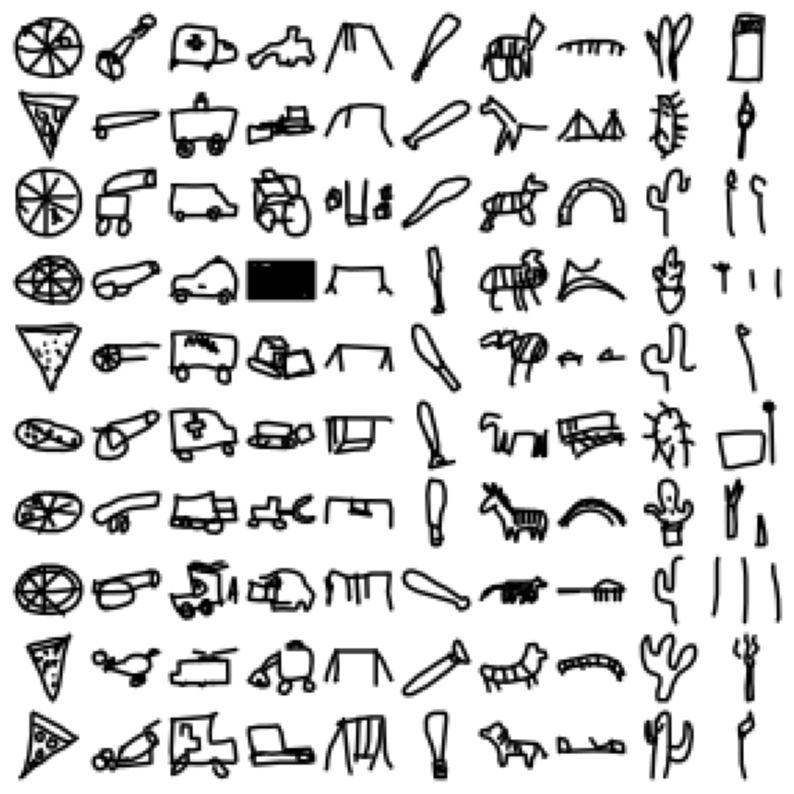

In [67]:
import random

with open('categories.txt') as f:
    all_class_names = f.readlines()


random.seed(RANDOM_SEED)

all_class_names = [x.strip().replace(' ', '_') for x in all_class_names] 

nb_classes = 10

# select random 10 classes
class_names = random.sample(all_class_names, nb_classes)

# you can also try those "hard" classes instead
#class_names = ['wheel', 'pizza', 'smiley_face', 'apple', 'potato', 'basketball', 'soccer_ball', 'brain', 'clock', 'circle']

print(class_names)

X_train, y_train, X_test, y_test = download_and_load(class_names)

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

visualize_classes(X_train, y_train)

## Create the model

In [68]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(64, (5, 5), input_shape=(28,28,1))) # 16 different 5x5 kernels -- so 16 feature maps
model.add(BatchNormalization())                      # weights normalization
model.add(Activation('relu') )                       # activation
model.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel


# Convolution Layer 2
model.add(Conv2D(32, (5, 5)))                        # 32 different 5x5 kernels -- so 32 feature maps
model.add(BatchNormalization())                      # weights normalization
model.add(Activation('relu'))                        # activation
model.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel

model.add(Flatten())                                 # Flatten final output matrix into a vector

# Fully Connected Layer 
model.add(Dense(128))                                # 128 FC nodes
model.add(Activation('relu'))                        # activation

# Fully Connected Layer                        
model.add(Dense(10))                                 # final 10 FC nodes
model.add(Activation('softmax'))                     # softmax activation


# we'll use the same optimizer
adam = tf.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [69]:
# data augmentation prevents overfitting by slightly changing the data randomly
# Keras has a great built-in feature to do automatic augmentation

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08, validation_split=0.2)

test_gen = ImageDataGenerator()

train_generator = gen.flow(X_train, Y_train, batch_size=128, subset='training')
valid_generator = gen.flow(X_train, Y_train, batch_size=128, subset='validation')
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [70]:
model.fit(train_generator, steps_per_epoch=64000//128, epochs=5, verbose=1, validation_data=valid_generator, validation_steps = 16000 // 128)

Epoch 1/5
500/500 [==============================] - 27s 48ms/step - loss: 0.7735 - accuracy: 0.7584 - val_loss: 0.8943 - val_accuracy: 0.7249
Epoch 2/5
500/500 [==============================] - 24s 49ms/step - loss: 0.4861 - accuracy: 0.8533 - val_loss: 0.7969 - val_accuracy: 0.7516
Epoch 3/5
500/500 [==============================] - 24s 48ms/step - loss: 0.4185 - accuracy: 0.8745 - val_loss: 1.0432 - val_accuracy: 0.6694
Epoch 4/5
500/500 [==============================] - 24s 48ms/step - loss: 0.3838 - accuracy: 0.8840 - val_loss: 0.5184 - val_accuracy: 0.8442
Epoch 5/5
500/500 [==============================] - 24s 48ms/step - loss: 0.3552 - accuracy: 0.8918 - val_loss: 0.5259 - val_accuracy: 0.8408


In [71]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

625/625 [==============================] - 2s 3ms/step - loss: 0.6194 - accuracy: 0.8317
Test score: 0.6194124817848206
Test accuracy: 0.8317499756813049


625/625 [==============================] - 1s 2ms/step
Confusion matrix, without normalization
[[2009    9   44    2    1    3    9    9    6   13]
 [  30 1575  267   14    1    4   47   19   15   18]
 [   3    6 1900    6    1    1    8    4    3    4]
 [  25   36  911  928    3    3   17    6    7   15]
 [  23   10   67   17 1848   10   17   20   10   31]
 [  45  218   20    0    2 1594    7   17   18   73]
 [  14   29   66   18    0    3 1845    5    7   12]
 [  20   94  170   20   27    1   97 1513   12   18]
 [  30    7   41    7    1    8   11    5 1846   33]
 [  50   66   92   28   16   88   30   13   51 1577]]


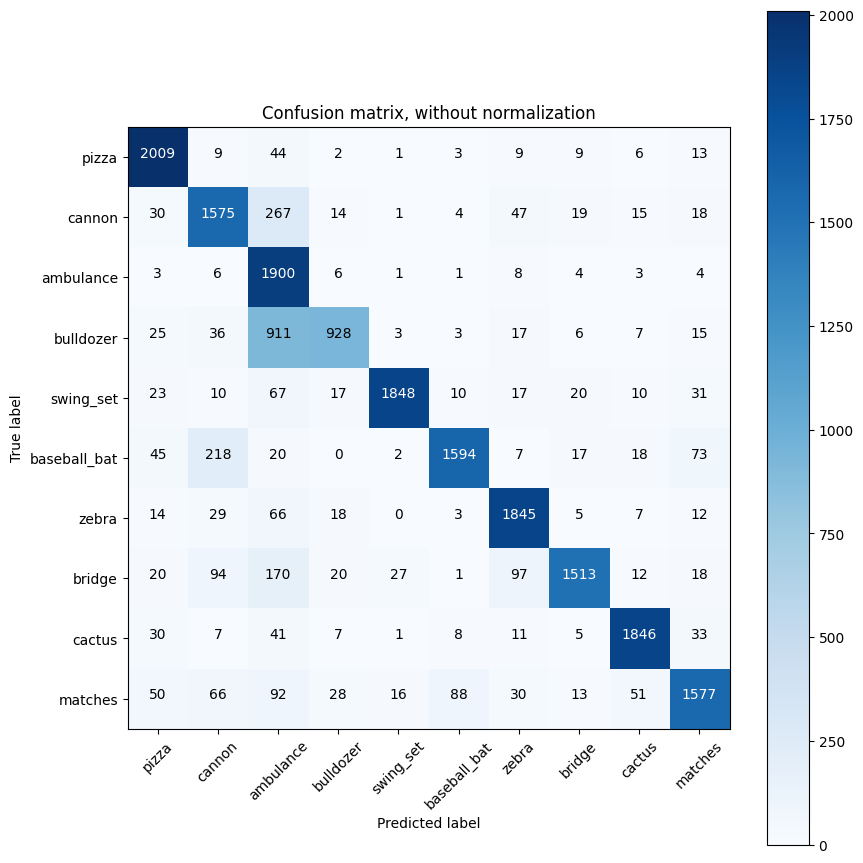

In [72]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted = model.predict(X_test)
predicted_classes = np.argmax(predicted, axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

cnf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

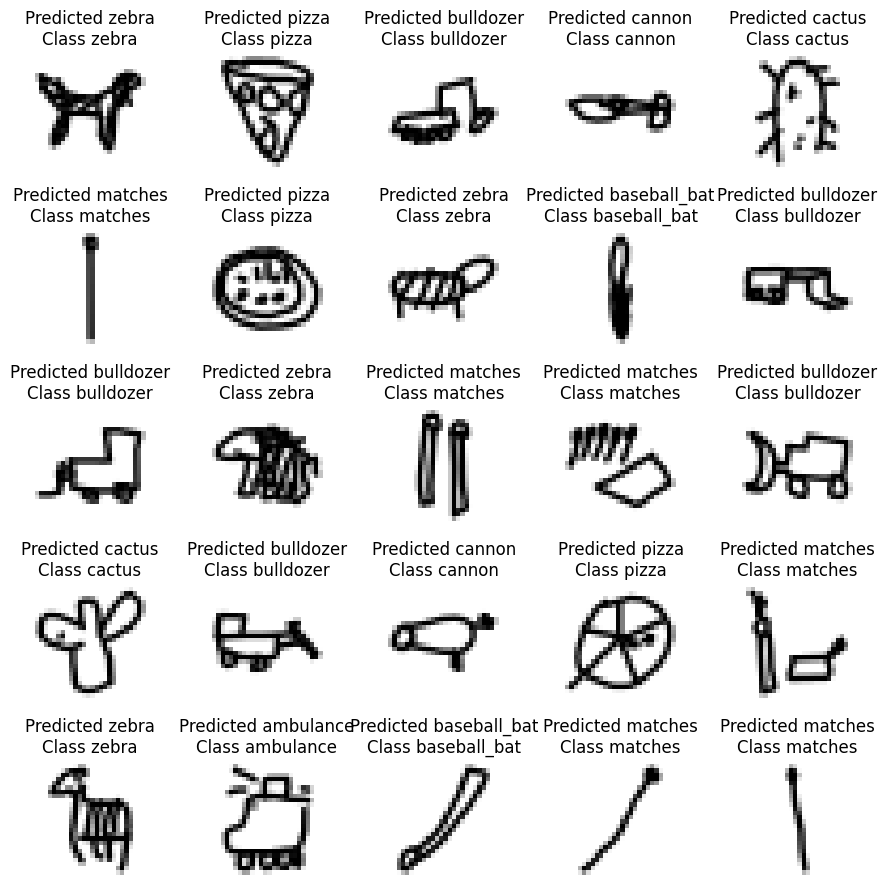

In [73]:
show_samples(correct_indices, predicted_classes, X_test, y_test, 5, class_names)

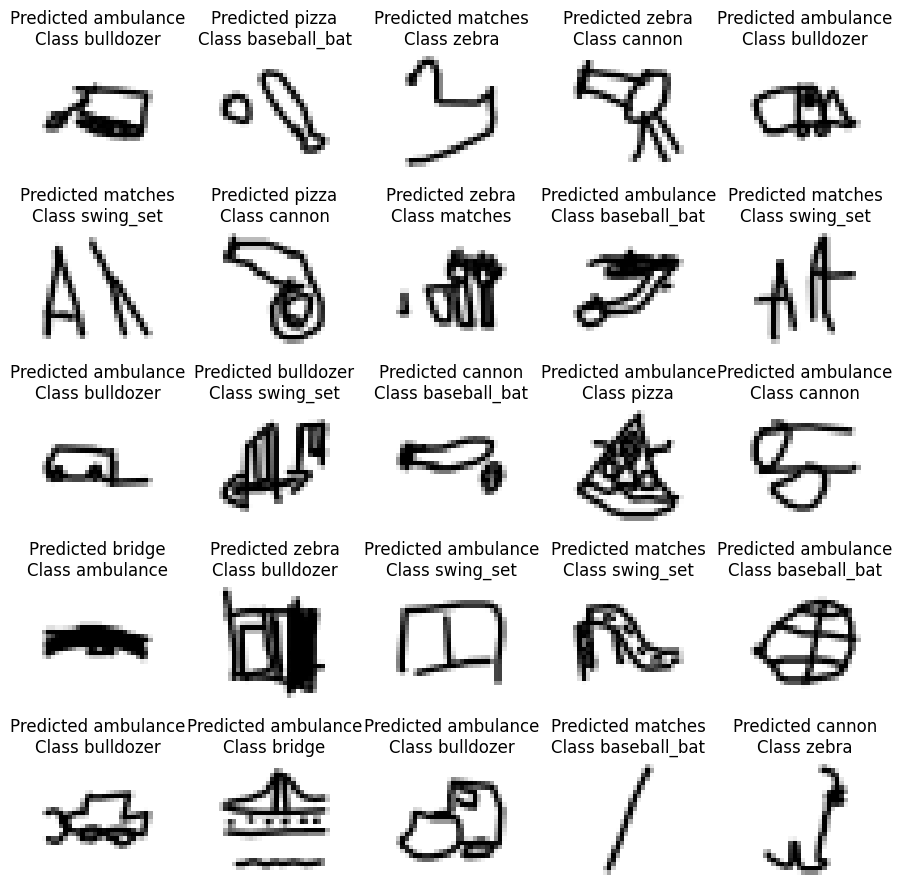

In [74]:
show_samples(incorrect_indices, predicted_classes, X_test, y_test, 5, class_names)

# CIFAR-10

## Ładowanie zbioru danych

In [75]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

y_train = y_train.reshape((1,-1))[0]
y_test = y_test.reshape((1,-1))[0]

print("Training matrix shape", X_train.shape, y_train.shape)
print("Testing matrix shape", X_test.shape, y_test.shape)

# one-hot format classes

nb_classes = 10 

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

cifar_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 [==============================] - 2s 0us/step
Training matrix shape (50000, 32, 32, 3) (50000,)
Testing matrix shape (10000, 32, 32, 3) (10000,)


## Podgląd zbioru treningowego

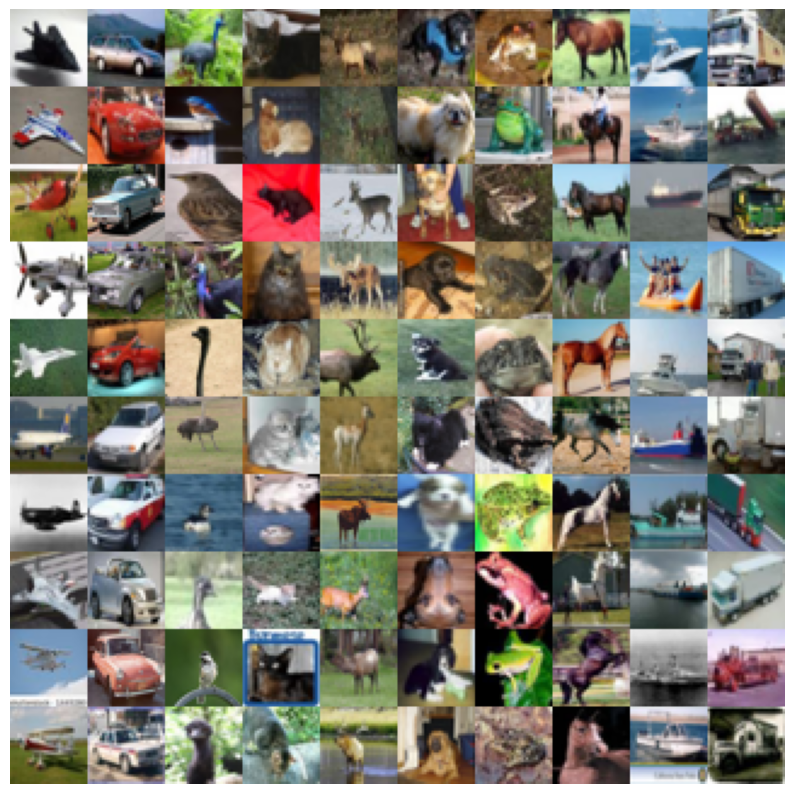

In [76]:
for i in range(0, 10):
  img_batch = X_train[y_train == i][0:10]
  img_batch = np.reshape(img_batch, (img_batch.shape[0]*img_batch.shape[1], img_batch.shape[2], img_batch.shape[3]))
  if i > 0:
    img = np.concatenate([img, img_batch], axis = 1)
  else:
    img = img_batch
plt.figure(figsize=(10,20))
plt.axis('off')
plt.imshow(img, cmap='gray')


## Przygotowanie modelu

In [77]:
def generate_model():
  model = Sequential()                                 # Linear stacking of layers

  # Convolution Layer 1
  model.add(Conv2D(16, (3, 3), input_shape=(32,32,3)))
  model.add(Activation('relu') )  

  # ...

  model.add(Flatten())                                 # Flatten final output matrix into a vector

  # ...

  # Fully Connected Layer                        
  model.add(Dense(10))                                 # final 10 FC nodes
  model.add(Activation('softmax'))                     # softmax activation

  model.summary()
  
  adam = tf.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  return model

In [78]:
model = generate_model()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 activation_22 (Activation)  (None, 30, 30, 16)        0         
                                                                 
 flatten_3 (Flatten)         (None, 14400)             0         
                                                                 
 dense_15 (Dense)            (None, 10)                144010    
                                                                 
 activation_23 (Activation)  (None, 10)                0         
                                                                 
Total params: 144,458
Trainable params: 144,458
Non-trainable params: 0
_________________________________________________________________


## Trening

In [79]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08, validation_split=0.2)

train_generator = gen.flow(X_train, Y_train, batch_size=128, subset='training')
valid_generator = gen.flow(X_train, Y_train, batch_size=128, subset='validation')

In [80]:
model.fit(train_generator, steps_per_epoch=40000//128, epochs=2, verbose=1, validation_data=valid_generator, validation_steps = 10000 // 128)

Epoch 1/2
312/312 [==============================] - 27s 82ms/step - loss: 1.7191 - accuracy: 0.3937 - val_loss: 1.5400 - val_accuracy: 0.4442
Epoch 2/2
312/312 [==============================] - 26s 83ms/step - loss: 1.4809 - accuracy: 0.4736 - val_loss: 1.4490 - val_accuracy: 0.4865


## Test

313/313 [==============================] - 1s 3ms/step - loss: 1.4295 - accuracy: 0.4978
Test score: 1.4295148849487305
Test accuracy: 0.49779999256134033
313/313 [==============================] - 1s 2ms/step
Confusion matrix, without normalization
[[551 141  28   5   9   9  17  21 150  69]
 [ 14 832   3   1   1   3  12   7  34  93]
 [ 99  84 300  16  53  99 165 104  44  36]
 [ 49  91  41  97  37 246 228 115  23  73]
 [ 49  54 110  15 235  70 224 196  24  23]
 [ 31  51  58  46  35 432 115 163  30  39]
 [  9  73  45  13  22  31 719  41  14  33]
 [ 22  60  26  11  16  65  58 638  16  88]
 [113 158   4   2   2   7  14  11 624  65]
 [ 31 314   6   2   1   6  24  27  39 550]]


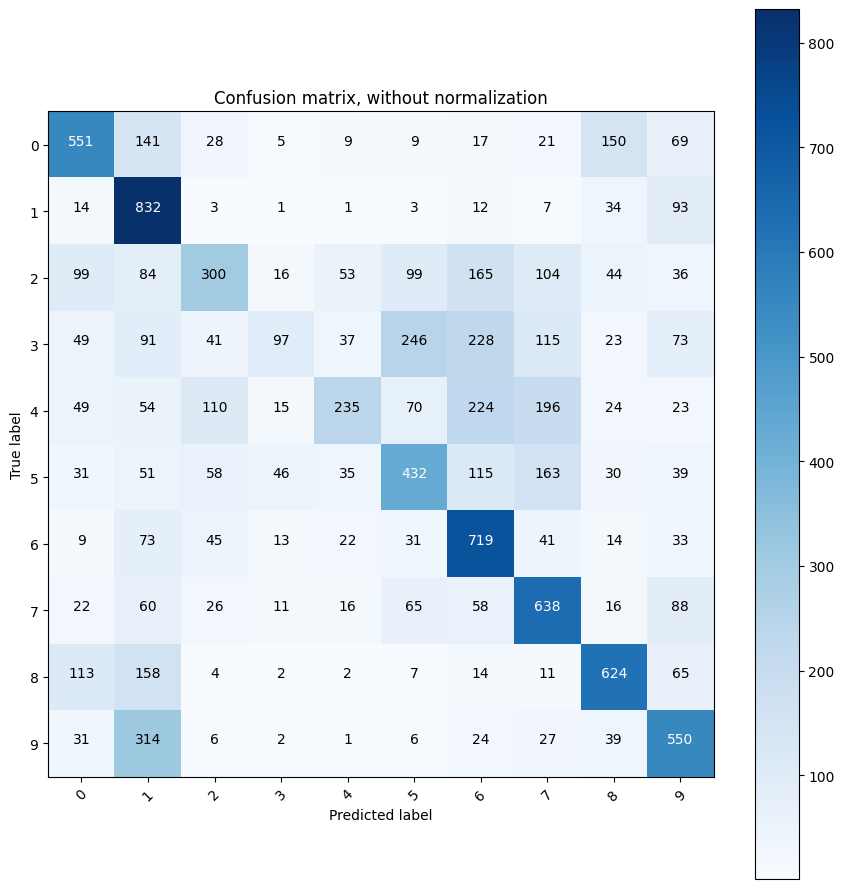

In [81]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted = model.predict(X_test)
predicted_classes = np.argmax(predicted, axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]


cnf_matrix = confusion_matrix(y_test, predicted_classes)

class_names = [str(i) for i in range(10)]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [82]:
def show_samples_rgb(indices, preds, images, labels, count=3, names = []):
    plt.figure()
    for i, sample in enumerate(indices[:count**2]):
        plt.subplot(count,count,i+1)
        plt.imshow(images[sample], interpolation='none')
        plt.axis('off')
        if len(names) > 0:
          plt.title("Predicted {}\nClass {}".format(names[int(preds[sample])], names[int(labels[sample])]))
        else:
          plt.title("Predicted {}\nClass {}".format(preds[sample], labels[sample]))          
    
    plt.tight_layout()

## Poprawne klasyfikacje

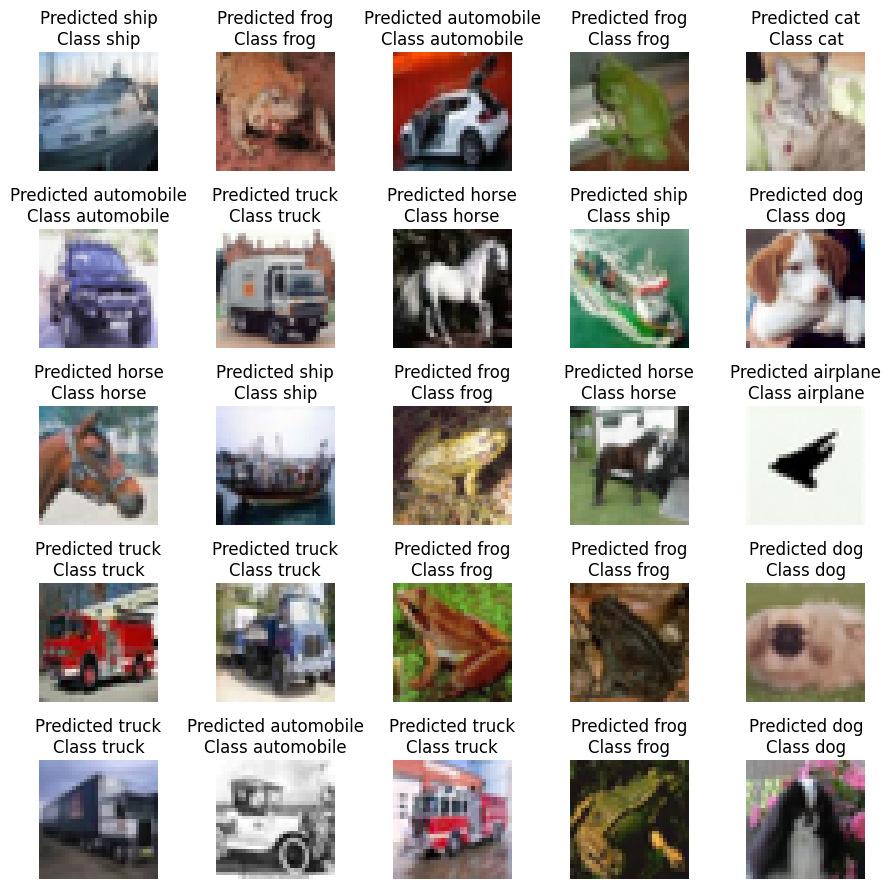

In [83]:
show_samples_rgb(correct_indices, predicted_classes, X_test, y_test, 5, cifar_names)

## Błędne klasyfikacje

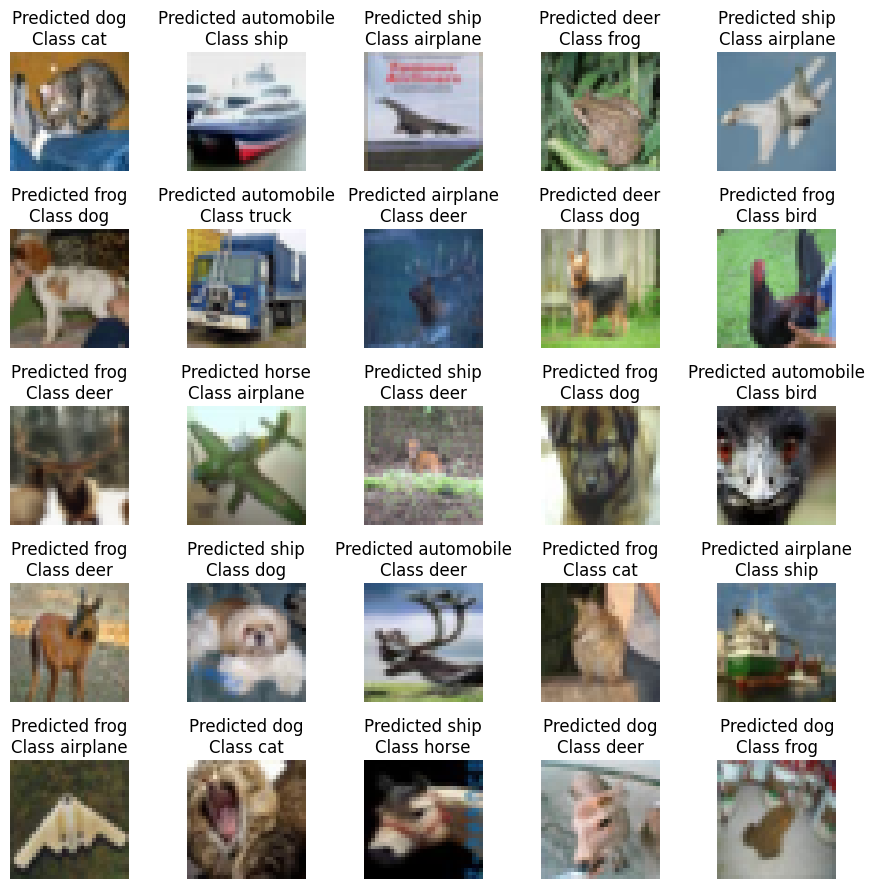

In [84]:
show_samples_rgb(incorrect_indices, predicted_classes, X_test, y_test, 5, cifar_names)